In [134]:
import chardet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unicodedata
from spellchecker import SpellChecker
from collections import Counter
import string
import nltk
import spacy
from PIL import Image
from wordcloud import WordCloud

nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') #pos_tag

import en_core_web_sm
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from gensim.models import Word2Vec, KeyedVectors


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [135]:
from google.colab import files

# Choose the file from your local machine
uploaded = files.upload()

Saving data_world.csv to data_world (11).csv
Saving kaggle.csv to kaggle (11).csv


### Data Cleaning

In [136]:
# Detect encoding
with open("data_world.csv", 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

'''
  Initially, data_world.csv had 6091 rows.
  After skipping on bad lines, there are 6090 rows in this dataset
  Finally, after dropping duplicates, the number of rows is now 5541.
'''

# Read CSV with detected encoding
data_world_df = pd.read_csv("data_world.csv", encoding=encoding, on_bad_lines='skip')

# Remove duplicate tweets
data_world_df = data_world_df.drop_duplicates(subset='tweet', keep='first')

# Change representation of 'existence' values
data_world_df['existence'] = data_world_df['existence'].map({'Yes': 1, 'No': -1, 'N/A': 0})

In [137]:
# Detect encoding
with open("kaggle.csv", 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

'''
  Initially, kaggle.csv had 43,943 rows.
  After dropping duplicates, the number of rows reduced to 41,033
  Finally, after removing rows labelled as "News", the dataset now has 31,960 rows
'''
# Repeat same steps for Kaggle dataset
kaggle_df = pd.read_csv("kaggle.csv", encoding=encoding, on_bad_lines='skip')
kaggle_df = kaggle_df.drop_duplicates(subset='message', keep='first')

# Remove rows where sentiment is labeled as News (value = 2)
kaggle_df = kaggle_df.loc[kaggle_df['sentiment'] != 2]

In [138]:
df_selected_columns = data_world_df[['tweet', 'existence']].rename(columns={'tweet': 'og_tweet','existence': 'label'})
df_kaggle_selected_columns = kaggle_df[['message', 'sentiment']].rename(columns={'message': 'og_tweet', 'sentiment': 'label'})

# Concatenate the two DataFrames vertically
df = pd.concat([df_selected_columns, df_kaggle_selected_columns], ignore_index=True)

#df.label.value_counts()
#df.info()

# 5066 rows with missing labels
missing_label_rows = df[df['label'].isnull()]
df.dropna(subset=['label'], inplace=True)

# Now the number of rows for both columns are equal
#df.info()
#round(df['label'].value_counts()*100/len(df),2)

In [139]:
'''
Extracting hashtags from dataset for visualization later
before tweets undergo pre-processing
'''

def extract_top_hashtags(tweets):

  hashtags_list = []

  for tweet in tweets:
      hashtags = re.findall(r"#(\w+)", tweet)
      hashtags_list.extend(hashtags)

  frequency = nltk.FreqDist(hashtags_list)

  hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()), 'count': list(frequency.values())})

  # Select the top 15 hashtags
  hashtag_df = hashtag_df.nlargest(15, columns="count")

  return hashtag_df

# Extracting the hashtags from tweets in each class
pro_hashtags = extract_top_hashtags(df['og_tweet'][df['label'] == 1])
anti_hashtags = extract_top_hashtags(df['og_tweet'][df['label'] == -1])
neutral_hashtags = extract_top_hashtags(df['og_tweet'][df['label'] == 0])


In [140]:
'''
Initializing a dataframe to store tweets awaiting classification labels
based on the selected model.
'''
test_df = df['og_tweet'].sample(n=7500, random_state=42)

# Remove selected tweets from the DataFrame
df = df.drop(test_df.index)
test_df = test_df.reset_index(drop=True).to_frame(name='og_tweet')

### Data Pre-Processing

In [141]:
# Function to fix encoding issues
def fix_encoding(text):
    try:
      decoded_text = text.encode('utf-8').decode('utf-8')
    except Exception as e:  # Catch other potential errors
      decoded_text = ''  # Return empty string for other errors
    return decoded_text

# Function to correct spelling
def correct_spelling(text):
    spell = SpellChecker()
    tokens = word_tokenize(text)
    corrected_tokens = []
    for word in tokens:
        corrected_word = spell.correction(word)
        if corrected_word is not None:
            corrected_tokens.append(corrected_word)
        else:
            corrected_tokens.append(word)
    corrected_text = ' '.join(corrected_tokens)
    return corrected_text

In [142]:
# Pre-processing
def clean_tweet(tweet):

  # Remove retweet texts "RT"
  tweet = re.sub(r'^RT[\s]+', '', tweet)

  # Converting to lower case
  tweet = tweet.lower()

  # Remove hyperlinks: both http and https
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
  tweet = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', tweet)
  tweet = re.sub(r"http\S+", '', tweet)

  # Remove placeholders saying [link] which was done by prior text cleaning
  tweet = re.sub(r'\[link\]', '', tweet)

  # Remove hashtags (only removing the hash # sign from the word)
  tweet = re.sub(r'#', '', tweet)

  # Remove numbers
  tweet = re.sub(r'\d+', '', tweet)

  # Remove mentions
  tweet = re.sub('@[\w]*', '', tweet)

  # Remove punctuation
  tweet = re.sub(r"[,.;:@#?!|\&/$]+\ *", '', tweet)

  # Remove diamond symbol
  tweet = re.sub(r"U+FFFD ", '', tweet)

  # Remove extra whitespace
  tweet = re.sub(r'\s\s+', '', tweet)

  # Remove leading spaces
  tweet = tweet.lstrip(' ')

  tweet = unicodedata.normalize('NFKD', tweet).encode('ascii','ignore').decode('utf-8', 'ignore')

  # Fix encoding issues
  tweet = fix_encoding(tweet)

  # Correct spelling
  # tweet = correct_spelling(tweet)

  return tweet

df['cleaned_tweet'] = df['og_tweet'].apply(clean_tweet)
test_df['processed_tweet'] = test_df['og_tweet'].apply(clean_tweet)

In [143]:
# Tokenizing
nlp = spacy.load('en_core_web_sm')
df['tokenized_tweet'] = df['cleaned_tweet'].apply(lambda x: nlp(x))
test_df['processed_tweet'] = test_df['processed_tweet'].apply(lambda x: nlp(x))

stop_words = stopwords.words('english')
stop_words += list(string.punctuation) # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
stop_words += list(string.ascii_lowercase) # letters from 'a' to 'z'

def clean_tokens(tokens):
  cleaned_tokens = [word.text for word in tokens if word.text not in set(stop_words)]
  return cleaned_tokens

df['tokenized_tweet'] = df['tokenized_tweet'].apply(clean_tokens)
test_df['processed_tweet'] = test_df['processed_tweet'].apply(clean_tokens)


In [144]:
# Removing rare words from dataset to reduce bias
all_tweets = [' '.join(tokens) for tokens in df['tokenized_tweet']]

def find_rare_words(threshold=2, all_text=all_tweets, top_n_rare_words=10):
  words = nltk.word_tokenize(' '.join(all_text))
  word_freq = Counter(words)

  rare_words = [word for word, freq in word_freq.items() if freq < threshold][:top_n_rare_words]

  return rare_words

def remove_rare_words(text, rare_words):
  filtered_words = [word for word in text if word not in rare_words]
  return filtered_words

rare_words_list = find_rare_words()
df['tokenized_tweet'] = df['tokenized_tweet'].apply(remove_rare_words, rare_words=rare_words_list)
test_df['tokenized_tweet'] = test_df['processed_tweet'].apply(remove_rare_words, rare_words=rare_words_list)


In [145]:
# Lemmatizing
def lemma(df):

  # Add part-of-speech tags to the 'tweet' column
  df['pos_tags'] = df['tokenized_tweet'].apply(nltk.tag.pos_tag)

  def get_wordnet_pos(tweet_tag):

    # Map Penn Treebank POS tags to WordNet POS tags.
    pos_mapping = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    return wordnet.NOUN

  lemmatizer = WordNetLemmatizer()

  # Lemmatize the 'tweet' column based on part-of-speech tags
  df['lemma'] = df['pos_tags'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for word, pos_tag in x])

  # ['apple', 'banana', 'orange'] -> 'apple banana orange'
  df['lemma'] = [' '.join(map(str, l)) for l in df['lemma']]

  df.drop('pos_tags', axis=1, inplace=True)

  return df

df = lemma(df)

In [146]:
# Lemmatizing unlabelled dataset
def test_lemma(test_df):

  # Add part-of-speech tags to the 'tweet' column
  test_df['pos_tags'] = test_df['tokenized_tweet'].apply(nltk.tag.pos_tag)

  def get_wordnet_pos(tweet_tag):

    # Map Penn Treebank POS tags to WordNet POS tags.
    pos_mapping = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    return wordnet.NOUN

  lemmatizer = WordNetLemmatizer()

  # Lemmatize the 'tweet' column based on part-of-speech tags
  test_df['lemma'] = test_df['pos_tags'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for word, pos_tag in x])

  # ['apple', 'banana', 'orange'] -> 'apple banana orange'
  test_df['lemma'] = [' '.join(map(str, l)) for l in test_df['lemma']]

  test_df.drop('pos_tags', axis=1, inplace=True)

  return test_df

test_df = test_lemma(test_df)

### Visualisations

In [147]:
# Finding the 25 most commonly mentioned words for each sentiment label
def calculate_word_frequency(text_corpus):

    count_vectorizer = CountVectorizer(stop_words='english')
    word_matrix = count_vectorizer.fit_transform(text_corpus)

    # Calculate the sum of words in the documents and determine the frequency of each word
    sum_words = word_matrix.sum(axis=0)
    word_freq = [(word, sum_words[0, i]) for word, i in count_vectorizer.vocabulary_.items()]

    # Sort the data based on frequencies in descending order
    sorted_word_frequencies = sorted(word_freq, key=lambda x: x[1], reverse=True)

    top_words_df = pd.DataFrame(word_freq, columns=['word', 'frequency'])

    # Select the words with highest frequencies
    top_words_df = top_words_df.head(25)

    return top_words_df

# Retrieving the top 25 words in each class
pro_top_25 = calculate_word_frequency(df['lemma'][df['label']==1])
anti_top_25 = calculate_word_frequency(df['lemma'][df['label']==-1])
neutral_top_25 = calculate_word_frequency(df['lemma'][df['label']==0])

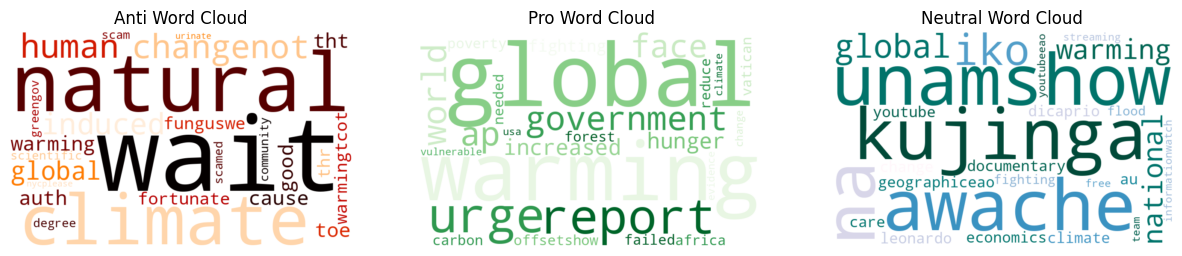

In [148]:
# Turning the above variables into lists to use as data for wordclouds
pro_list = ' '.join([text for text in pro_top_25['word']])
anti_list = ' '.join([text for text in anti_top_25['word']])
neutral_list = ' '.join([text for text in neutral_top_25['word']])

# Generating wordclouds
anti_wc = WordCloud(background_color='white', colormap='gist_heat', width = 800, height = 500).generate(anti_list)
pro_wc = WordCloud(background_color='white', colormap='Greens', width = 800, height = 500).generate(pro_list)
neutral_wc = WordCloud(background_color='white', colormap='PuBuGn_r', width = 800, height = 500).generate(neutral_list)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Anti Word Cloud
axes[0].imshow(anti_wc, interpolation='bilinear')
axes[0].set_title('Anti Word Cloud')
axes[0].axis('off')

# Plot Pro Word Cloud
axes[1].imshow(pro_wc, interpolation='bilinear')
axes[1].set_title('Pro Word Cloud')
axes[1].axis('off')

# Plot Neutral Word Cloud
axes[2].imshow(neutral_wc, interpolation='bilinear')
axes[2].set_title('Neutral Word Cloud')
axes[2].axis('off')

# Show the plot
plt.show()

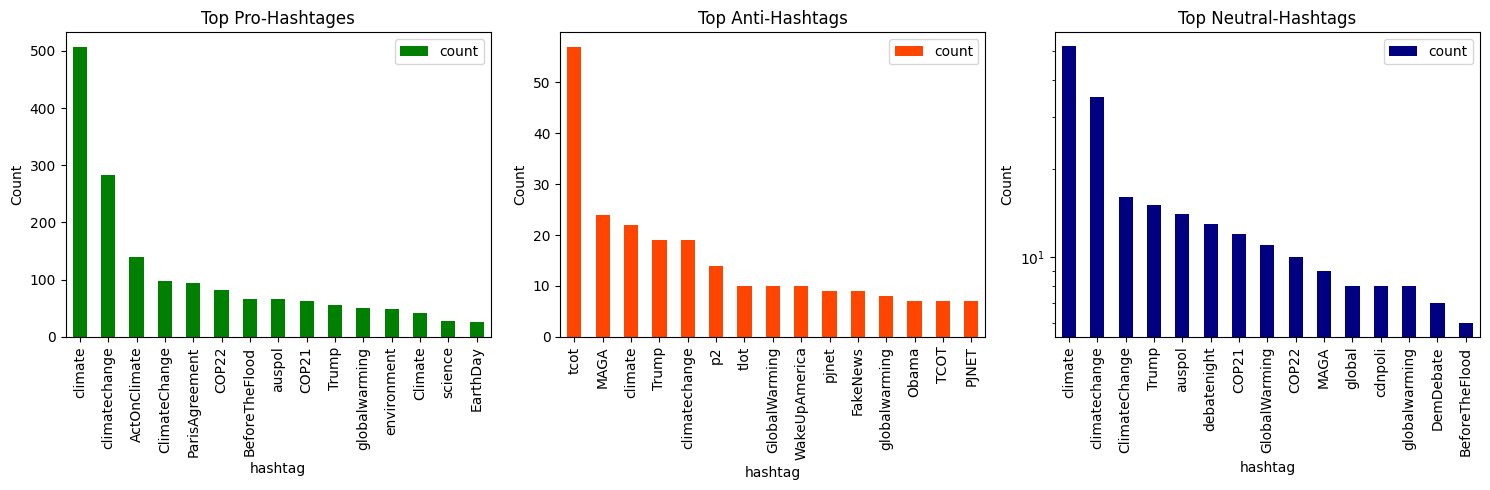

In [149]:
# Hashtag frequency visualisation
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.yscale('log')

# Plot top hashtags for each sentiment category
pro_hashtags.set_index('hashtag').plot(kind='bar', ax=axes[0], color='green', title='Top Pro-Hashtages')
axes[0].set_ylabel('Count')

anti_hashtags.set_index('hashtag').plot(kind='bar', ax=axes[1], color='orangered', title='Top Anti-Hashtags')
axes[1].set_ylabel('Count')

neutral_hashtags.set_index('hashtag').plot(kind='bar', ax=axes[2], color='navy', title='Top Neutral-Hashtags')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()



Sentiment Analysis: Naive Bayes

In [150]:
# Separate dataset into feature and target variables
x = df['lemma']
y = df['label']

# Dividing data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=42)

# Vectorize text to numbers
vec = CountVectorizer(stop_words='english')
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()

# Naive Bayes Approach
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb.score(x_test, y_test)

nb_pred = nb.predict(x_test)
accuracy = accuracy_score(y_test, nb_pred)
f1 = f1_score(y_test, nb_pred, average="weighted")
print(classification_report(y_test, nb_pred))


KeyboardInterrupt: 

In [ ]:
# Predict sentiment for test_df using Naive Bayes
X_test = vec.transform(test_df['lemma']).toarray()
test_df['nb_sentiment'] = nb.predict(X_test)


### K-Means

In [151]:
# Word2Vec Embedding

tokenized_tweets = df['tokenized_tweet'].tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_tweets, vector_size=100, window=5, min_count=1, workers=4)

# Generate word embeddings
word_embeddings = word2vec_model.wv

# Function to aggregate word vectors for each document
def aggregate_vectors(tokens):
    vectors = [word_embeddings[word] for word in tokens if word in word_embeddings]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Apply aggregation function to your tokenized documents
X = [aggregate_vectors(tokens) for tokens in tokenized_tweets]


# Perform dimensionality reduction for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

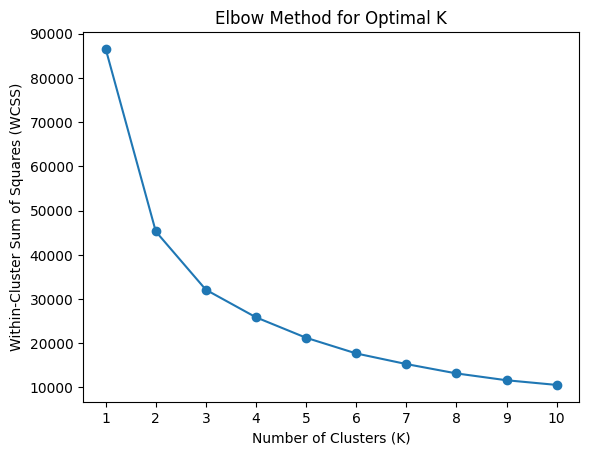

In [152]:
# Initialize a list to store the within-cluster sum of squares (WCSS) values
wcss = []

# Define the range of clusters to try
k_range = range(1, 11)

# Fit K-means clustering for each value of k and calculate WCSS
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.show()

In [153]:
k = 5
# Perform K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_2d)
kmeans.fit(X)
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


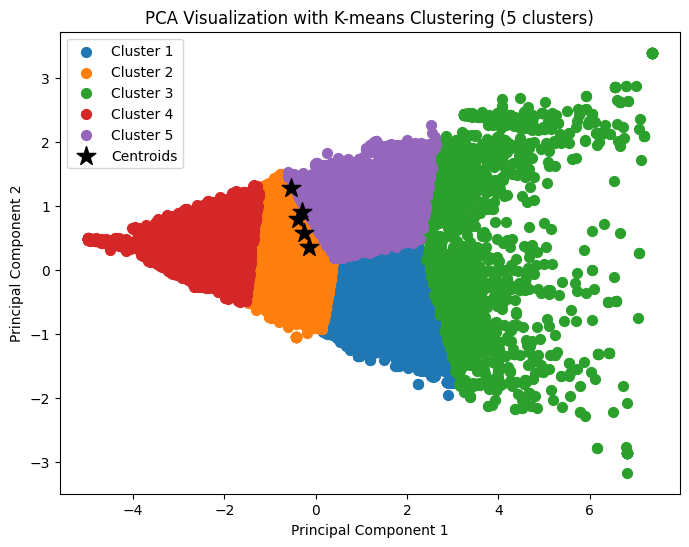

In [154]:
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(X_2d[cluster_labels == i, 0], X_2d[cluster_labels == i, 1], s=50, label=f'Cluster {i+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='*', label='Centroids')
plt.title('PCA Visualization with K-means Clustering (5 clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [155]:
# def print_top_terms_per_cluster(X, cluster_assignments, feature_names, n_top_terms=10):
#     for cluster_id in range(len(set(cluster_assignments))):  # Get the number of unique clusters
#         cluster_indices = np.where(cluster_assignments == cluster_id)[0]  # Indices of data points in the cluster

#         if len(cluster_indices) > 0:
#           cluster_indices = np.array(X)[cluster_indices]
#           cluster_X = X[cluster_indices]  # Data points in the cluster
#           cluster_term_freq = np.sum(cluster_X, axis=0)
#           top_term_indices = np.argsort(cluster_term_freq)[::-1][:n_top_terms]
#           top_terms = [feature_names[i] for i in top_term_indices]
#           print(f"\nCluster {cluster_id + 1} Top Terms:")
#           for term in top_terms:
#               print(term)
#         else:
#             print(f"\nCluster {cluster_id + 1} is empty")

# # Print top terms per cluster
# print_top_terms_per_cluster(X, labels, feature_names)

TypeError: only integer scalar arrays can be converted to a scalar index